In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

Here we will analyse the latent space of the neural networks trained in different ways. To do this easily, we need to look at the TSNE or UMAP of the encoding for each sample and the resulting actual value of the objective (adaptation + sensitivity + precision). First we will create the model according to the settings for each run, load its weights, load the real data, run it through the encoder to get the *z*, and plot that with the actual functionality of the circuit.

In [70]:
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.math import arrayise
from evoscaper.utils.load_helpers import read_csv_with_tuples
from bioreaction.misc.misc import load_json_as_dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import os
import jax

In [71]:
fn_saves = os.path.join('weight_saves', '01_cvae',
                        '2024_12_19__16_10_53_saves_hs16_ls32_nlayers2_adam')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__15_33_42_adapt')
# fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__21_26_05_prec_sens') 
saves_loaded = load_json_as_dict(fn_saves)
df_hpos = pd.DataFrame(load_json_as_dict('data/2025_01_10__20_18_58/df_hpos_main.json'))
params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

In [72]:
# for hpos in df_hpos.iterrows():

hpos = df_hpos.iloc[0]
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    _, 
    encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

In [73]:
x.shape

(779, 256, 6)

In [ ]:
h_all = encoder(params, rng, np.concatenate([x, cond], axis=-1))
h_all = h_all.reshape(np.prod(h_all.shape[:-1]), -1)
cond_rev_all = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond, col=config_dataset.objective_col[0]).reshape(np.prod(cond.shape[:-1]), -1).squeeze()
x_rev_all = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).reshape(np.prod(x.shape[:-1]), -1).squeeze()

i_cond = 0
idxs_cond = np.where(np.argmax(cond.reshape(np.prod(cond.shape[:-1]), -1), axis=-1) == i_cond)
# idxs_cond = np.where(np.argmax(cond, axis=-1) == i_cond)

h = h_all[idxs_cond]
cond_rev = cond_rev_all[idxs_cond]
x_rev = x_rev_all[idxs_cond]


In [76]:
perplexity = 30
tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, max_iter=1000)
tsne_result = tsne.fit_transform(h)


<Figure size 800x600 with 0 Axes>

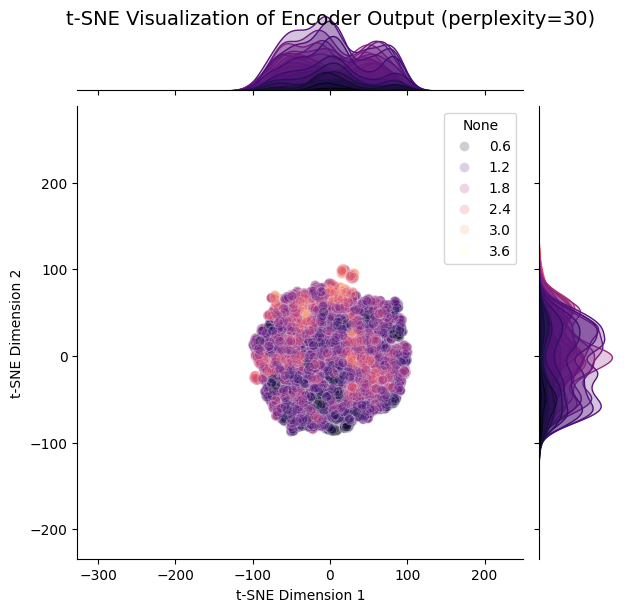

<Figure size 800x600 with 0 Axes>

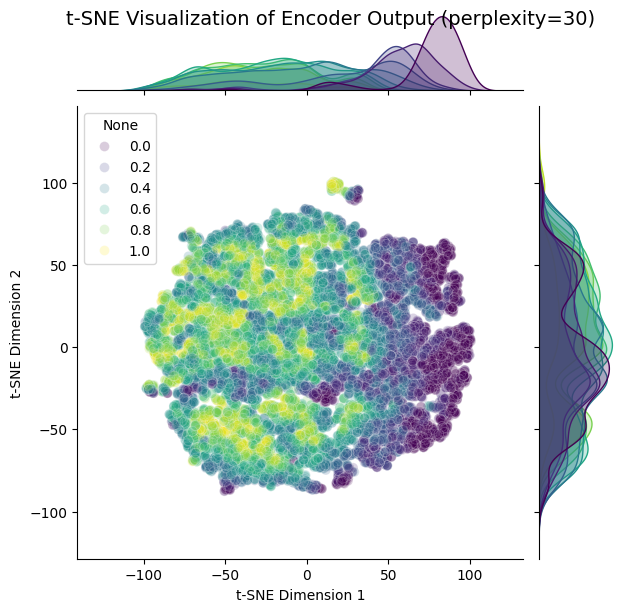

<Figure size 800x600 with 0 Axes>

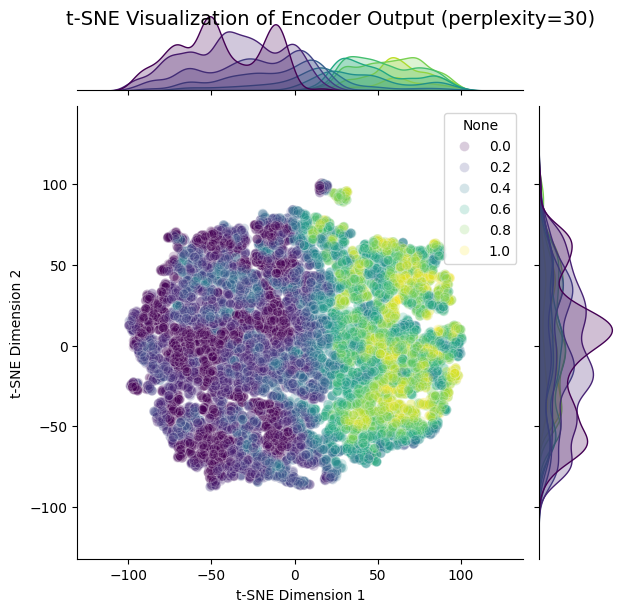

<Figure size 800x600 with 0 Axes>

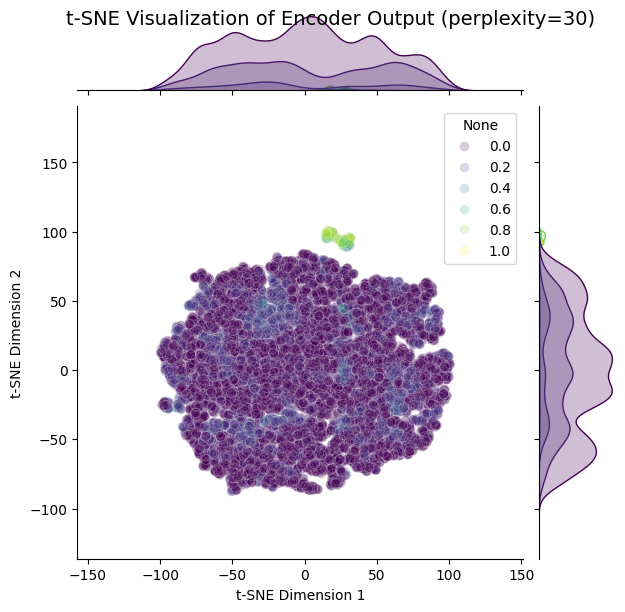

<Figure size 800x600 with 0 Axes>

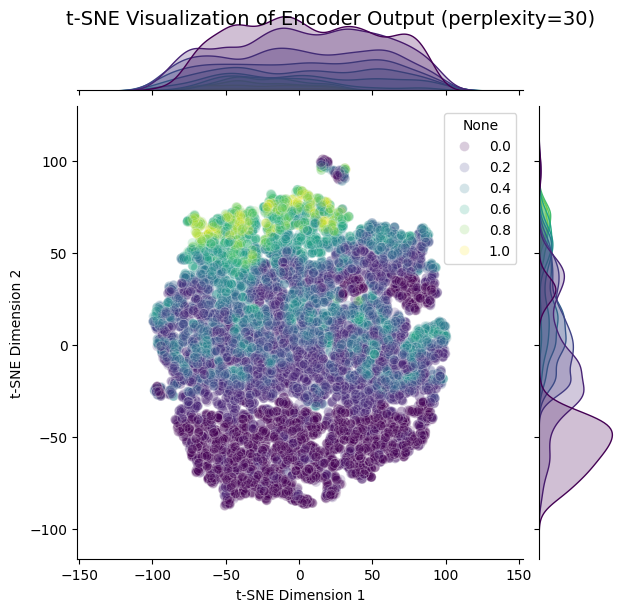

<Figure size 800x600 with 0 Axes>

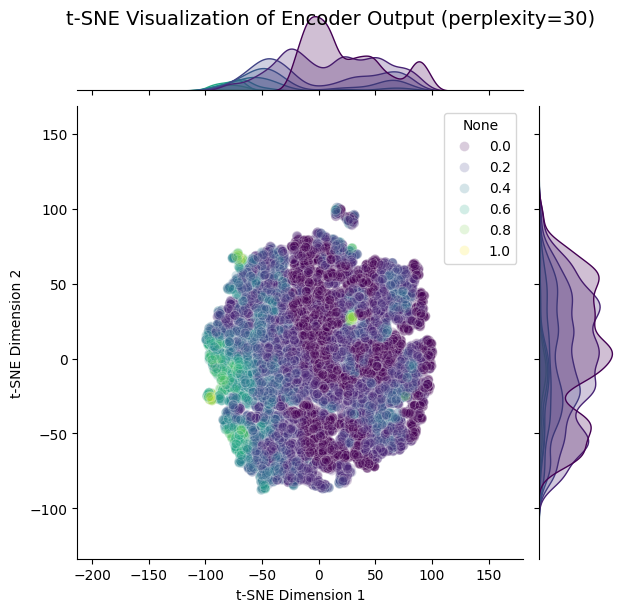

<Figure size 800x600 with 0 Axes>

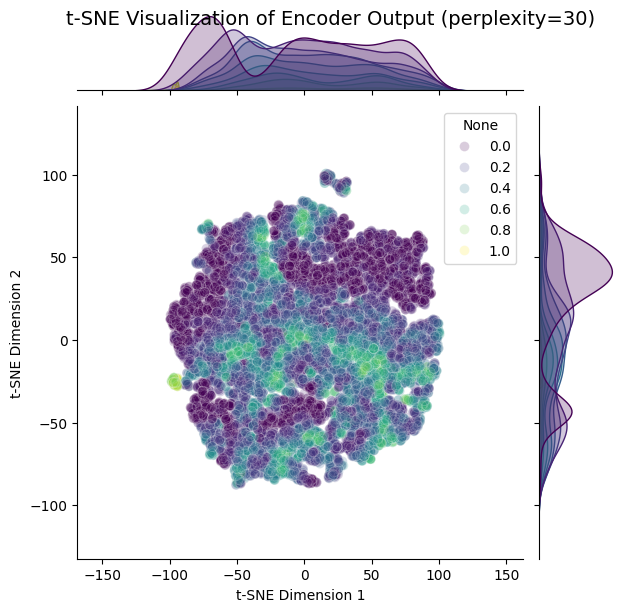

In [79]:
def plot_tsne(tsne_result, cond_rev, perplexity, ax, palette='viridis'):
    # sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=cond_rev, palette='viridis', s=50, alpha=0.2)
    # sns.kdeplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=cond_rev, palette='viridis', s=50, alpha=0.2)
    sns.jointplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=cond_rev, palette=palette, s=50, alpha=0.2, ax=ax)
    plt.suptitle(f"t-SNE Visualization of Encoder Output (perplexity={perplexity})", fontsize=14)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    

# for i_cond in np.arange(10):
x_rev = np.round(x.reshape(np.prod(x.shape[:-1]), -1)[idxs_cond], 1)
plot_tsne(tsne_result, x_rev.sum(axis=-1), perplexity, palette='magma')
for i in np.arange(x_rev.shape[-1]):
    plt.figure(figsize=(8, 6))
    plot_tsne(tsne_result, x_rev[..., i], perplexity, ax=plt.subplot(1, x.shape[-1], i+1))

    # plt.show()

Text(0.5, 1.0, 'Embedding of model')

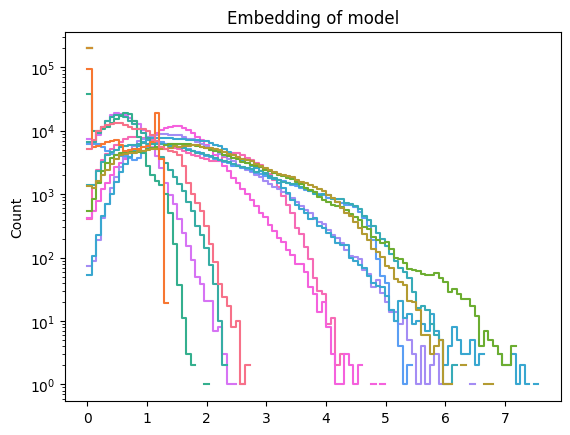

In [78]:
i_enc = encoder(params, rng, np.concatenate([x, cond], axis=-1))
sns.histplot(i_enc.reshape(np.prod(i_enc.shape[:-1]), -1), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
plt.title('Embedding of model')